Imports

In [69]:
# ! pip install datasets

In [73]:
# # ! pip install accelerate>=0.26.0
# ! pip install transformers[torch]

In [71]:
# ! pip uninstall transformers accelerate -y
# ! pip install "transformers[torch]" "accelerate>=0.26.0"

In [72]:
# ! pip install evaluate

In [74]:
# ! pip install spacy
# ! python -m spacy download en_core_web_sm

In [75]:
import pandas as pd
from transformers import pipeline
import numpy as np
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments,AutoModelForSequenceClassification
from datasets import Dataset
from sklearn.model_selection import train_test_split
import evaluate
import spacy
import torch


In [84]:
import pandas as pd
import nltk
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Download required resources
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\james\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\james\AppData\Roaming\nltk_data...
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\james\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\james\AppData\Roaming\nltk_data...


True

In [76]:
print("PyTorch version:", torch.__version__)
print("CUDA version PyTorch was built with:", torch.version.cuda)
print("Is CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA device:", torch.cuda.get_device_name(0))

PyTorch version: 2.7.1+cu118
CUDA version PyTorch was built with: 11.8
Is CUDA available: True
CUDA device: Quadro P2000 with Max-Q Design


#### Read in Dataset

In [77]:
events_df = pd.read_csv('Nat Cat Events.csv')

#### Only Consider Titles

In [78]:
titles = events_df['title']

#### Remove duplicates & Null values

In [79]:
titles = titles.drop_duplicates().reset_index(drop=True)

In [80]:
titles = titles.dropna().reset_index(drop=True)

In [81]:
titles_df = pd.DataFrame(titles)

#### Step 1: Filter Articles with no Location

In [96]:
if torch.cuda.is_available():
    spacy.require_gpu() # Use GPU
    nlp = spacy.load("en_core_web_trf")
    print("Using trf (GPU Supported)")
else:
    nlp = spacy.load("en_core_web_sm") # Use CPU
    print("Using sm")

Using trf (GPU Supported)


In [22]:
# def has_location(title):
#     doc = nlp(title)
#     return any(ent.label_ in ("GPE", "LOC") for ent in doc.ents)


# has_loc = [has_location(title) for title in titles_df['title'].values]
# titles_df['has_loc'] = has_loc

In [ ]:
# docs = list(nlp.pipe(titles_df['title'].values, batch_size=32))
# titles_df['has_loc'] = [any(ent.label_ in ("GPE", "LOC") for ent in doc.ents) for doc in docs]

c:\Users\james\AppData\Local\Programs\Python\Python310\lib\site-packages\thinc\shims\pytorch.py:114: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self._mixed_precision):


In [ ]:
# titles_df.to_csv('titles_df_has_loc.csv', index=False)

In [82]:
titles_df = pd.read_csv('titles_df_has_loc.csv')

In [90]:
loc_titles_df = titles_df[titles_df['has_loc']]

### Step X: Manually filter articles unrelated to Natural Catastrophe's

In [ ]:
# Initialise tools
#stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [86]:
# List of disaster-related keyword
disaster_keywords = {
    "earthquake", "flood", "tsunami", "hurricane", "cyclone", "volcano",
    "eruption", "wildfire", "landslide", "tornado", "avalanche", "storm", "drought"
}

In [112]:
def preprocess_and_filter(text):
    # Tokenize and lowercase
    tokens = word_tokenize(text.lower())
    # Remove stopwords and non-alphabetic tokens
    tokens = [t for t in tokens if t.isalpha() and t not in stop_words]
    # Lemmatize only (no stemming)
    lemmas = [lemmatizer.lemmatize(t) for t in tokens]
    # Check for disaster-related terms
    has_disaster_word = any(word in disaster_keywords for word in lemmas)
    return ' '.join(lemmas), has_disaster_word

In [113]:
loc_titles_df[["processed_title", "is_disaster"]] = loc_titles_df["title"].apply(
    lambda x: pd.Series(preprocess_and_filter(x))
)

C:\Users\james\AppData\Local\Temp\ipykernel_41572\667380779.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loc_titles_df[["processed_title", "is_disaster"]] = loc_titles_df["title"].apply(


In [114]:
loc_disaster_titles_df = loc_titles_df[loc_titles_df['is_disaster']]

In [115]:
loc_disaster_titles_df

,title,has_loc,processed_title,is_disaster
4,"Tornados , scorchers and ice storm : Top 10 we...",True,tornado scorcher ice storm top weather event a...,True
12,Japan earthquakes : Coastal residents told to ...,True,japan earthquake coastal resident told evacuat...,True
16,DSWD DROMIC Report on the Tornado Incident in ...,True,dswd dromic report tornado incident brgy rizal...,True
19,New state report : Wildfire smoke increased de...,True,new state report wildfire smoke increased deat...,True
23,In Photos : NASA Juno Flies Just 930 Miles Abo...,True,photo nasa juno fly mile volcano jupiter viole...,True
...,...,...,...,...
65143,Borno flood committee disburses N18 billion to...,True,borno flood committee disburses billion household,True
65144,Wild weather and storm chaos puts dampener on ...,True,wild weather storm chaos put dampener scotland...,True
65145,Mississippi neighbors help each other recover ...,True,mississippi neighbor help recover storm,True
65151,North Coast braces for potential floods as mor...,True,north coast brace potential flood rain forecas...,True


### Step X: Find articles of event's that have occurred

In [116]:
docs = list(nlp.pipe(loc_disaster_titles_df['title'].values, batch_size=32))
loc_disaster_titles_df['has_occurred'] = [any(ent.label_ in ("DATE") for ent in doc.ents) for doc in docs]

c:\Users\james\AppData\Local\Programs\Python\Python310\lib\site-packages\thinc\shims\pytorch.py:114: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self._mixed_precision):
C:\Users\james\AppData\Local\Temp\ipykernel_41572\151705521.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loc_disaster_titles_df['has_occurred'] = [any(ent.label_ in ("DATE") for ent in doc.ents) for doc in docs]


In [ ]:
# docs = list(nlp.pipe(loc_disaster_titles_df['title'].values, batch_size=32))
# loc_disaster_titles_df['occurrence_and_location'] = [any(ent.label_ in ("DATE") for ent in doc.ents)
#                                                and any(ent.label_ in ("GPE", "LOC") for ent in doc.ents)
#                                               for doc in docs]

In [117]:
loc_disaster_titles_df[loc_disaster_titles_df['has_occurred']]

,title,has_loc,processed_title,is_disaster,has_occurred
16,DSWD DROMIC Report on the Tornado Incident in ...,True,dswd dromic report tornado incident brgy rizal...,True,True
24,2023 finishes as 3rd warmest in central Indian...,True,finish warmest central indiana tornado statewi...,True,True
45,Factbox - Major earthquakes in Japan since Kob...,True,factbox major earthquake japan since kobe disa...,True,True
54,"Indonesia , Floods and Landslides in Pasaman (...",True,indonesia flood landslide pasaman west sumater...,True,True
128,Not Over Yet : More earthquakes of 7 magnitude...,True,yet earthquake magnitude strike japan week,True,True
...,...,...,...,...,...
65120,13 confirmed tornadoes in Alabama on Saturday ...,True,confirmed tornado alabama saturday national we...,True,True
65121,"Dickinson hit hardest by Saturday tornadoes , ...",True,dickinson hit hardest saturday tornado weather...,True,True
65142,"Harrison County EMA , Gulfport city leaders as...",True,harrison county ema gulfport city leader asses...,True,True
65144,Wild weather and storm chaos puts dampener on ...,True,wild weather storm chaos put dampener scotland...,True,True


In [106]:
loc_disaster_occurred_titles_df = loc_disaster_titles_df[loc_disaster_titles_df['has_occurred']]

In [109]:
loc_disaster_occurred_titles_df.to_csv('loc_disaster_occurred_titles_df.csv', index=False)

In [ ]:
# ##### Experiment #######
# def nlp_check_title_criteria(title):
#     doc = nlp(title)
#     return any(ent.label_ in ["DATE"] for ent in doc.ents) and any(ent.label_ in ("GPE", "LOC") for ent in doc.ents) for doc in docs

# docs = list(nlp.pipe(loc_disaster_titles_df['title'].values, batch_size=32))
# loc_disaster_titles_df['has_occurred'] = [any(ent.label_ in ("DATE") for ent in doc.ents)
#                                               and any(ent.label_ in ("GPE", "LOC") for ent in doc.ents)
#                                               for doc in docs]

#### Step X: Build supervised-model to evaluate any edge cases NLP might have missed

Sample False population Dataset

In [110]:
sample_size = len(loc_disaster_occurred_titles_df)
df_remaining = titles_df[~titles_df.index.isin(loc_disaster_occurred_titles_df.index)]
false_pop = df_remaining.sample(n=sample_size, random_state=42)

# Optional: reset index if needed
# df_sampled = df_sampled.reset_index(drop=True)

In [111]:
false_pop

,title,has_loc,processed_title,is_disaster
10548,Nisqually quake hit 23 years ago,False,nisqual quak hit year ago,False
14060,Houston hail threat increases for Thursday ; H...,True,houston hail threat increas thursday know,False
12442,Get the umbrella ready for later this week,False,get umbrella readi later week,False
4054,At least 50 injured in major earthquake on Chi...,True,least injur major earthquak china kyrgyzstan b...,False
4712,Filipina among 4 bodies recovered from Hawaii ...,True,filipina among bodi recov hawaii wildfir,False
...,...,...,...,...
26255,"More rain , less heat ! Tracking a stormier pa...",False,rain le heat track stormier pattern weekend de...,False
25644,Quebec homeowner recalls moment tornado hit hi...,True,quebec homeown recal moment tornado hit farmho...,True
43438,Fatal fire - ABC7 New York,False,fatal fire new york,False
31185,Policy Brief : As Wildfires Grow More Intense ...,True,polici brief wildfir grow intens ai could next...,False


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import classification_report, roc_curve, auc

In [ ]:


# Split data
X_train, X_test, y_train, y_test = train_test_split(
    loc_disaster_occurred_titles_df['title'], 
    loc_disaster_occurred_titles_df['natural_catastrophe_event'], 
    test_size=0.2, 
    random_state=42, 
    stratify=confident_df["natural_catastrophe_event"]
)

# Pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(solver='liblinear'))
])

# Hyperparameter grid
param_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__min_df': [1, 3, 5],
    'clf__C': [0.01, 0.1, 1, 10],
    'clf__penalty': ['l1', 'l2']
}

# Grid search
grid = GridSearchCV(
    pipeline, 
    param_grid, 
    cv=5, 
    scoring='roc_auc', 
    n_jobs=-1, 
    verbose=1
)
grid.fit(X_train, y_train)

# ✅ Calibrate with Isotonic Regression (fit on test set to avoid train leakage)
calibrated_clf = CalibratedClassifierCV(grid.best_estimator_, method='isotonic', cv='prefit')
calibrated_clf.fit(X_test, y_test)  # Fit calibration model on held-out test set

# Predict probabilities
y_proba_cal = calibrated_clf.predict_proba(X_test)[:, 1]
y_pred_cal = calibrated_clf.predict(X_test)

# Classification report
print("Best Parameters:", grid.best_params_)
print("\nClassification Report (Calibrated):")
print(classification_report(y_test, y_pred_cal))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba_cal)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Calibrated)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# ✅ Calibration Curve
prob_true, prob_pred = calibration_curve(y_test, y_proba_cal, n_bins=10)

plt.figure(figsize=(8, 5))
plt.plot(prob_pred, prob_true, marker='o', label='Calibrated (Isotonic)')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curve")
plt.legend()
plt.grid(True)
plt.show()


Use a Zero-Shot-Classifier to capture confidence of a title implying a natural catastrophe event

In [ ]:
if torch.cuda.is_available():
    classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli", device=0) # Use GPU
else:
    classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli") # Use CPU

Device set to use cuda:0


In [15]:
labels = ["natural catastrophe event"]
# CPU
#results = classifier(titles_df['title'].tolist(), candidate_labels=labels, batch_size=32)
# GPU
results = classifier(titles_df['title'].tolist(), candidate_labels=labels, batch_size=64, device=0)

In [16]:
label_confidences = []

for i in results:
    label_confidences.append(i['scores'][0])

Save Titles with confidence labels

In [17]:
titles_df['nce_label_confidence'] = label_confidences
titles_df.to_csv('titles_with_label_confidences.csv', index=False)

In [2]:
titles_df = pd.read_csv('titles_with_label_confidences.csv')

In [68]:
titles_df.head()

,title,has_loc
0,2023 was a year of extreme weather in Southern...,True
1,HAWAIIAN VOLCANO OBSERVATORY DAILY UPDATE Mond...,False
2,How to Protect Your Family from Tornadoes,False
3,Iceland volcanoes bring tourists to island cou...,False
4,"Tornados , scorchers and ice storm : Top 10 we...",True


<Axes: >

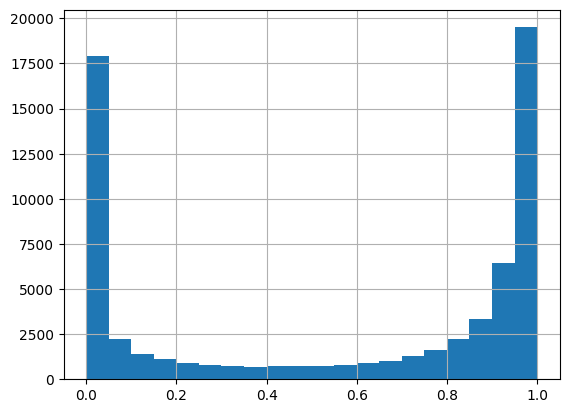

In [4]:
titles_df['nce_label_confidence'].hist(bins=20)

From this histogram we can see that the majority of predictions are < 0.05 or > 0.95

### Step 3: Build Classifier to infer on Edge cases

#### Now Let's build a supervised-classifier using these Zero-Shot-Classifier confident predictions to build a predictor for the unconfident Zero-Shot-Classifier predictions

We will Fine-Tune a pre-trained BERT model

Prepare Dataset

In [5]:
# Take rows of confident predictions
confident_df = titles_df[(titles_df['nce_label_confidence'] > 0.95) | (titles_df['nce_label_confidence'] < 0.05)]
# Take rows of uncofident predictions for later inference
unconfident_df = titles_df[(titles_df['nce_label_confidence'] < 0.95) & (titles_df['nce_label_confidence'] > 0.05)]

In [6]:
# Create binary label for training
confident_df['natural_catastrophe_event'] = np.where(confident_df['nce_label_confidence'] > 0.95, 1, np.where(confident_df['nce_label_confidence'] < 0.05, 0, np.nan)).astype(int)

C:\Users\james\AppData\Local\Temp\ipykernel_41572\2027430008.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  confident_df['natural_catastrophe_event'] = np.where(confident_df['nce_label_confidence'] > 0.95, 1, np.where(confident_df['nce_label_confidence'] < 0.05, 0, np.nan)).astype(int)


In [7]:
confident_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37297 entries, 4 to 65157
Data columns (total 3 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   title                      37297 non-null  object 
 1   nce_label_confidence       37297 non-null  float64
 2   natural_catastrophe_event  37297 non-null  int32  
dtypes: float64(1), int32(1), object(1)
memory usage: 1019.8+ KB


Train Test Split

In [34]:
confident_df = confident_df.reset_index(drop=True)
train_df, test_df = train_test_split(confident_df, test_size=0.2, random_state=42, stratify=confident_df["natural_catastrophe_event"])

Using `title` as the independent variable and `natural_catastrophe_event` as the target variable

LR Model

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Parameters: {'clf__C': 10, 'clf__penalty': 'l2', 'tfidf__min_df': 3, 'tfidf__ngram_range': (1, 2)}

Classification Report (Calibrated):
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      3581
           1       0.99      0.98      0.98      3879

    accuracy                           0.98      7460
   macro avg       0.98      0.98      0.98      7460
weighted avg       0.98      0.98      0.98      7460



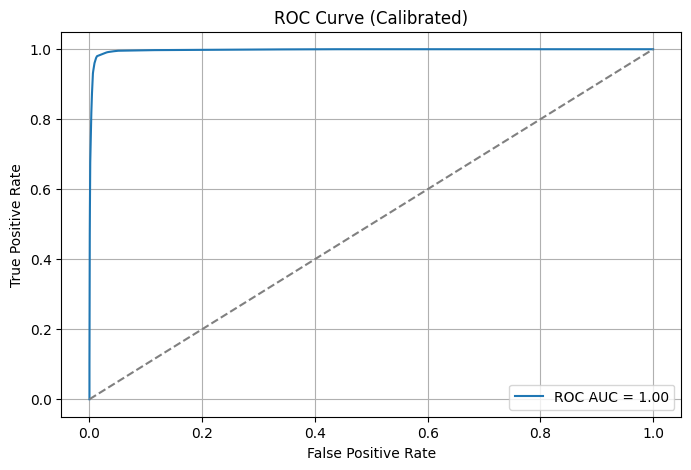

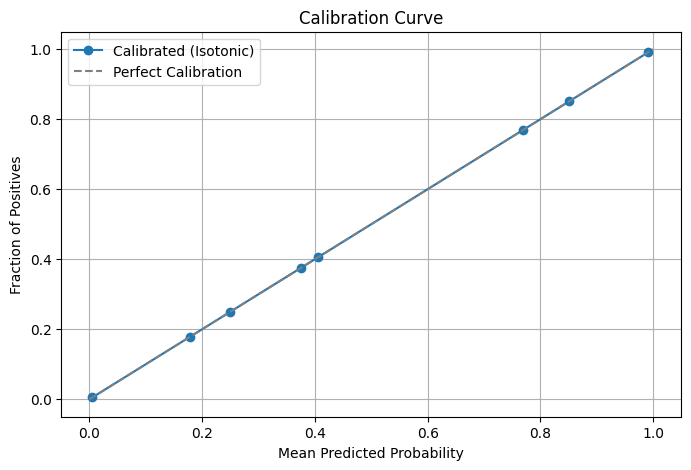

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import classification_report, roc_curve, auc

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    titles_df['title'], 
    confident_df['natural_catastrophe_event'], 
    test_size=0.2, 
    random_state=42, 
    stratify=confident_df["natural_catastrophe_event"]
)

# Pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(solver='liblinear'))
])

# Hyperparameter grid
param_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__min_df': [1, 3, 5],
    'clf__C': [0.01, 0.1, 1, 10],
    'clf__penalty': ['l1', 'l2']
}

# Grid search
grid = GridSearchCV(
    pipeline, 
    param_grid, 
    cv=5, 
    scoring='roc_auc', 
    n_jobs=-1, 
    verbose=1
)
grid.fit(X_train, y_train)

# ✅ Calibrate with Isotonic Regression (fit on test set to avoid train leakage)
calibrated_clf = CalibratedClassifierCV(grid.best_estimator_, method='isotonic', cv='prefit')
calibrated_clf.fit(X_test, y_test)  # Fit calibration model on held-out test set

# Predict probabilities
y_proba_cal = calibrated_clf.predict_proba(X_test)[:, 1]
y_pred_cal = calibrated_clf.predict(X_test)

# Classification report
print("Best Parameters:", grid.best_params_)
print("\nClassification Report (Calibrated):")
print(classification_report(y_test, y_pred_cal))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba_cal)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Calibrated)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# ✅ Calibration Curve
prob_true, prob_pred = calibration_curve(y_test, y_proba_cal, n_bins=10)

plt.figure(figsize=(8, 5))
plt.plot(prob_pred, prob_true, marker='o', label='Calibrated (Isotonic)')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curve")
plt.legend()
plt.grid(True)
plt.show()


In [61]:
calibrated_clf

CalibratedClassifierCV(cv='prefit',
                       estimator=Pipeline(steps=[('tfidf',
                                                  TfidfVectorizer(min_df=3,
                                                                  ngram_range=(1,
                                                                               2))),
                                                 ('clf',
                                                  LogisticRegression(C=10,
                                                                     solver='liblinear'))]),
                       method='isotonic')

In [62]:
calibrated_clf.predict(unconfident_df['title'])

array([1, 0, 1, ..., 1, 1, 0])

In [64]:
unconfident_df['title'][1]

'HAWAIIAN VOLCANO OBSERVATORY DAILY UPDATE Monday , January 1 , 2024 , 19 : 00 UTC | USGS Hazard Notification System ( HANS ) for Volcanoes'

In [11]:
# Set target variable to 'labels' for training compatibility
train_df = train_df.rename(columns={"natural_catastrophe_event": "labels"})
test_df = test_df.rename(columns={"natural_catastrophe_event": "labels"})

In [12]:
train_dataset = Dataset.from_pandas(train_df[['title', 'labels']])
test_dataset = Dataset.from_pandas(test_df[['title', 'labels']])

# Tokenize
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
def tokenize(example): return tokenizer(example["title"], truncation=True, padding="max_length")
tokenized_train = train_dataset.map(tokenize, batched=True)
tokenized_test = test_dataset.map(tokenize, batched=True)

c:\Users\james\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Map: 100%|██████████| 7460/7460 [00:03<00:00, 2118.47 examples/s]


In [13]:
tokenized_train

Dataset({
    features: ['title', 'labels', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 29837
})

In [14]:
# # Rename label column to 'labels' for Trainer compatibility
# tokenized_train = train_dataset.rename_column("natural_catastrophe_event", "labels")
# # Set format for PyTorch
# tokenized_train.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

# # And for the test set
# tokenized_test = train_dataset.rename_column("natural_catastrophe_event", "labels")
# tokenized_test.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

In [22]:
# Load model
#model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

model = AutoModelForSequenceClassification.from_pretrained("nreimers/MiniLM-L6-H384-uncased", num_labels=2)

c:\Users\james\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\james\.cache\huggingface\hub\models--nreimers--MiniLM-L6-H384-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Some weights of BertForSequenceClassification were not initialized from the model 

In [23]:
# Train
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=1,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=16,
    evaluation_strategy="epoch",  # Evaluate at end of each epoch
    logging_dir="./logs",
    logging_steps=1,
    save_strategy="epoch",        # Save checkpoint every epoch
    load_best_model_at_end=True,  # Load best model at end based on eval metric
    metric_for_best_model="roc_auc",
    greater_is_better=True,
    no_cuda=False,
    fp16=True # Speed up training
)

In [24]:
metric = evaluate.load("roc_auc")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = np.exp(logits) / np.exp(logits).sum(axis=-1, keepdims=True)  # softmax
    pos_probs = probs[:, 1]  # probability of class 1
    return metric.compute(prediction_scores=pos_probs, references=labels)

trainer = Trainer(model=model, args=training_args, train_dataset=tokenized_train, eval_dataset=tokenized_test, compute_metrics=compute_metrics)


In [25]:
trainer.train(resume_from_checkpoint=True)

  0%|          | 1/933 [00:13<3:21:30, 12.97s/it]

{'loss': 0.6934, 'learning_rate': 4.9946409431939984e-05, 'epoch': 0.0}


  0%|          | 2/933 [00:27<3:32:59, 13.73s/it]

{'loss': 0.697, 'learning_rate': 4.989281886387996e-05, 'epoch': 0.0}


  0%|          | 3/933 [00:42<3:39:33, 14.17s/it]

{'loss': 0.6928, 'learning_rate': 4.983922829581994e-05, 'epoch': 0.0}


  0%|          | 4/933 [00:56<3:41:42, 14.32s/it]

{'loss': 0.6876, 'learning_rate': 4.9785637727759915e-05, 'epoch': 0.0}


  1%|          | 5/933 [01:11<3:45:26, 14.58s/it]

{'loss': 0.7053, 'learning_rate': 4.9732047159699896e-05, 'epoch': 0.01}


  1%|          | 6/933 [01:25<3:42:43, 14.42s/it]

{'loss': 0.7023, 'learning_rate': 4.967845659163987e-05, 'epoch': 0.01}


  1%|          | 7/933 [01:40<3:45:20, 14.60s/it]

{'loss': 0.6916, 'learning_rate': 4.962486602357985e-05, 'epoch': 0.01}


  1%|          | 8/933 [01:55<3:46:11, 14.67s/it]

{'loss': 0.6915, 'learning_rate': 4.9571275455519834e-05, 'epoch': 0.01}


  1%|          | 9/933 [02:10<3:46:31, 14.71s/it]

{'loss': 0.6953, 'learning_rate': 4.951768488745981e-05, 'epoch': 0.01}


  1%|          | 10/933 [02:24<3:44:51, 14.62s/it]

{'loss': 0.7028, 'learning_rate': 4.946409431939979e-05, 'epoch': 0.01}


  1%|          | 11/933 [02:38<3:42:28, 14.48s/it]

{'loss': 0.6886, 'learning_rate': 4.9410503751339765e-05, 'epoch': 0.01}


  1%|▏         | 12/933 [02:53<3:44:23, 14.62s/it]

{'loss': 0.6893, 'learning_rate': 4.9356913183279746e-05, 'epoch': 0.01}


  1%|▏         | 13/933 [03:09<3:49:09, 14.94s/it]

{'loss': 0.6869, 'learning_rate': 4.930332261521972e-05, 'epoch': 0.01}


  2%|▏         | 14/933 [03:23<3:45:49, 14.74s/it]

{'loss': 0.6852, 'learning_rate': 4.92497320471597e-05, 'epoch': 0.02}


  2%|▏         | 15/933 [03:37<3:42:53, 14.57s/it]

{'loss': 0.6769, 'learning_rate': 4.9196141479099684e-05, 'epoch': 0.02}


KeyboardInterrupt: 